# **Fine-Grained Sentiment Analysis (5 classes) Yelp Reviews**

### Step 1: Install & Import Dependencies

In [1]:
!pip install -q transformers==4.41.2 peft==0.11.1 accelerate==0.31.0 datasets


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve, auc,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback, AutoConfig
)
from peft import LoraConfig, TaskType, get_peft_model

### Step 2: Mount Google Drive & Load Data

In [3]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

#file_path = "/content/drive/MyDrive/Yelp Reviews.csv"
#df = pd.read_csv(file_path, encoding='ISO-8859-1')
#df = df[['Text', 'Sentiment']].dropna()
#df.head()

# Path to your dataset on the server
file_path = "/home/arafatmdeasin/usman/project/dataset/Yelp Reviews.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df[['Text', 'Sentiment']].dropna()
df.head()


,Text,Sentiment
0,dr. goldberg offers everything i look for in a...,5
1,"Unfortunately, the frustration of being Dr. Go...",2
2,Been going to Dr. Goldberg for over 10 years. ...,4
3,Got a letter in the mail last week that said D...,4
4,I don't know what Dr. Goldberg was like before...,1


In [4]:
total_instances = len(df)
print(f"Total instances: {total_instances}")

sentiment_counts = df['Sentiment'].value_counts()
print("Number of instances per sentiment:")
print(sentiment_counts)

Total instances: 85000
Number of instances per sentiment:
Sentiment
1    19557
2    17293
3    16872
4    16365
5    14913
Name: count, dtype: int64


### Step 3: Visualize Dataset Distribution

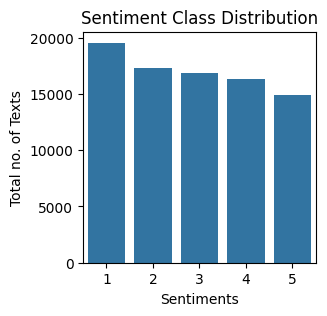

In [5]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiments")
plt.ylabel("Total no. of Texts")
plt.grid(False)
plt.show()


### Step 4: Encode Labels

In [6]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

print("Label Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

Label Mapping:
1: 0
2: 1
3: 2
4: 3
5: 4


### Step 5: Train-Test Split

In [7]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}, Test size: {len(test_texts)}")

Train size: 68000, Val size: 8500, Test size: 8500


### Step 6: Tokenization

In [8]:
base_model_name = "bert-base-multilingual-uncased"
finetuned_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


### Step 7: Dataset Class

In [9]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset   = SentimentDataset(val_encodings, val_labels)
test_dataset  = SentimentDataset(test_encodings, test_labels)

### Step 8: Define Metrics Function

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    proba = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    acc = accuracy_score(labels, preds) * 100
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    sims = []
    for i in range(len(labels)):
        true_onehot = np.zeros(proba.shape[1])
        true_onehot[labels[i]] = 1
        sims.append(cosine_similarity([true_onehot], [proba[i]])[0][0])
    similarity_score = np.mean(sims) * 100
    confidence_score = np.mean(np.max(proba, axis=1)) * 100

    return {
        "accuracy": acc,
        "precision": prec * 100,
        "recall": rec * 100,
        "f1": f1 * 100, 
        "similarity_score": similarity_score,
        "confidence_score": confidence_score,
    }


### Step 9: Evaluate Without Fine-Tuning

In [11]:
baseline_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model_name)

baseline_trainer = Trainer(
    model=baseline_model,
    args=TrainingArguments(
        output_dir="./results",
        per_device_eval_batch_size=32
    ),
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

baseline_metrics = baseline_trainer.evaluate()

print("\n===== Performance of Pretrained Transformer Model =====\n")

metrics_to_show = [
    "accuracy",
    "precision",
    "recall",
    "f1",
    "similarity_score",
    "confidence_score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in baseline_metrics:
        print(f"{metric} is: {baseline_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {baseline_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {baseline_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {baseline_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance of Pretrained Transformer Model =====

accuracy is: 56.55%
precision is: 56.21%
recall is: 56.52%
f1 is: 56.11%
similarity_score is: 66.16%
confidence_score is: 59.74%

===== Evaluation Details =====
Eval Loss: 1.0053
Runtime: 78.1705 sec
Samples per second: 108.737


### Step 9.1: Confusion Matrix (Without Fine-Tuning)

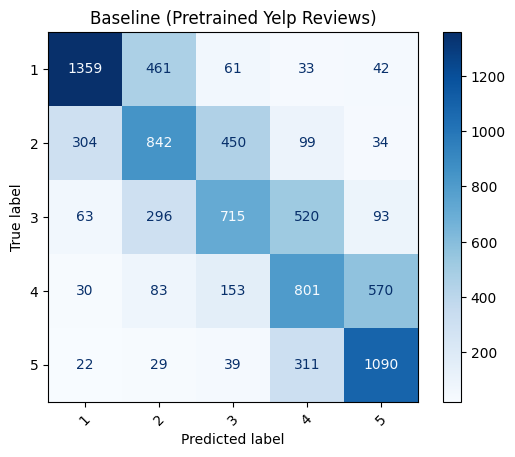

In [12]:
preds = baseline_trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)

class_names = label_encoder.classes_

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("Baseline (Pretrained Yelp Reviews)")
plt.show()

### Step 10: Base Model Fine-Tuning Configuration & Training

In [13]:
config = AutoConfig.from_pretrained(
    base_model_name,
    num_labels=5,
    hidden_dropout_prob=0.4,
    attention_probs_dropout_prob=0.3,
    classifier_dropout=0.4
)

model_base = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    config=config
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1.5e-5,
    weight_decay=0.15,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    logging_strategy="epoch",
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=1,
    save_total_limit=2,
    max_grad_norm=1.0,
    lr_scheduler_type="cosine",
    seed=42,
    dataloader_pin_memory=False,
)

trainer_base = Trainer(
    model=model_base,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=2),
    ]
)

trainer_base.train()

/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Similarity Score,Confidence Score
1,1.190000,0.932152,59.823529,60.972632,59.677346,59.822282,68.383981,63.370632
2,0.963400,0.905907,61.105882,61.430917,60.794877,60.889458,69.417885,68.623062
3,0.898500,0.887704,63.117647,62.470564,62.834632,62.479937,70.499189,72.254448
4,0.861000,0.889566,63.070588,62.369038,62.702141,62.389815,70.523086,72.589890


TrainOutput(global_step=17000, training_loss=0.9782161649816177, metrics={'train_runtime': 3243.9467, 'train_samples_per_second': 83.848, 'train_steps_per_second': 5.241, 'total_flos': 7.1568134750208e+16, 'train_loss': 0.9782161649816177, 'epoch': 4.0})

#### Step 10.1: Fine-Tuned Base Model Evaluation & Performance Analysis

In [14]:
finetuned_metrics = trainer_base.evaluate(test_dataset)

print("\n===== Performance after Fine-Tuning Base Model =====\n")

metrics_to_show = [
    "accuracy",
    "precision",
    "recall",
    "f1",
    "similarity_score",
    "confidence_score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in finetuned_metrics:
        print(f"{metric} is: {finetuned_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {finetuned_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {finetuned_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {finetuned_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance after Fine-Tuning Base Model =====

accuracy is: 62.24%
precision is: 61.48%
recall is: 61.83%
f1 is: 61.49%
similarity_score is: 69.92%
confidence_score is: 71.96%

===== Evaluation Details =====
Eval Loss: 0.9051
Runtime: 23.662 sec
Samples per second: 359.226


#### Step 10.2: Confusion Matrix Analysis

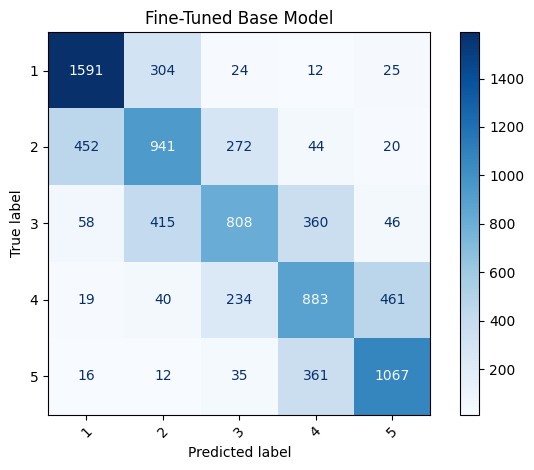

In [15]:
preds = trainer_base.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)

class_names = label_encoder.classes_

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
    cmap="Blues",
    xticks_rotation=45
)
plt.title("Fine-Tuned Base Model")
plt.tight_layout()
plt.show()

#### Step 10.3: Training Progress Visualization & Loss Analysis

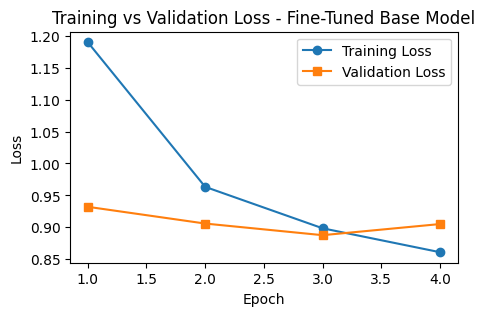

In [16]:
logs_base = trainer_base.state.log_history

train_loss_base = {}
eval_loss_base = {}

for log in logs_base:
    if "loss" in log and "epoch" in log:
        train_loss_base[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_base[float(log["epoch"])] = log["eval_loss"]

epochs_base = sorted(set(train_loss_base.keys()) | set(eval_loss_base.keys()))
train_vals_base = [train_loss_base.get(e, None) for e in epochs_base]
eval_vals_base = [eval_loss_base.get(e, None) for e in epochs_base]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_base, train_vals_base, label="Training Loss", marker="o")
plt.plot(epochs_base, eval_vals_base, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Fine-Tuned Base Model")
plt.legend()
plt.grid(False)
plt.show()


### Step 11: Adapter (LoRA) Model Configuration & Training

In [17]:
adapter_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=5
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.3,
    target_modules=["query", "key", "value", "dense"],
    bias="none",
    modules_to_save=["classifier"]
)

adapter_model = get_peft_model(adapter_model, peft_config)
adapter_model.print_trainable_parameters()

adapter_args = TrainingArguments(
    output_dir="./results-adapter",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=8,
    weight_decay=0.1,
    warmup_ratio=0.1,
    logging_dir="./logs-adapter",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to="none",
    seed=42,
    fp16=True,
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
    logging_steps=100,
    save_total_limit=2,
    lr_scheduler_type="cosine",
    dataloader_pin_memory=False,
    remove_unused_columns=True
)

trainer_adapter = Trainer(
    model=adapter_model,
    args=adapter_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3),
    ]
)

trainer_adapter.train()

adapter_metrics = trainer_adapter.evaluate(test_dataset)
print("Performance with Adapter (LoRA):", adapter_metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


trainable params: 1,343,237 || all params: 168,703,498 || trainable%: 0.7962


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Similarity Score,Confidence Score
1,1.101300,0.913026,59.482353,61.121617,59.299421,59.671016,68.615455,62.149281
2,0.884800,0.870171,61.505882,63.240006,61.073118,61.315136,70.185557,68.587715
3,0.814800,0.804974,64.894118,65.810105,64.566872,64.912647,72.503018,68.346748
4,0.765200,0.832125,65.329412,64.505766,64.892172,64.227068,72.540415,73.357155
5,0.717800,0.803964,66.435294,65.654007,66.099765,65.729571,73.226896,74.179008
6,0.674500,0.813349,66.305882,65.548834,65.972456,65.552833,73.063368,75.637886
7,0.643000,0.830731,66.270588,66.056690,66.036528,66.024869,72.907196,76.839325
8,0.622900,0.837151,66.235294,65.864836,65.931951,65.884123,72.872204,77.505882


/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface

Performance with Adapter (LoRA): {'eval_loss': 0.8456630110740662, 'eval_accuracy': 66.47058823529412, 'eval_precision': 66.26266748812787, 'eval_recall': 66.14794164761018, 'eval_f1': 66.19896975777527, 'eval_similarity_score': 72.71013812292772, 'eval_confidence_score': 76.71243286132812, 'eval_runtime': 35.1984, 'eval_samples_per_second': 241.488, 'eval_steps_per_second': 7.557, 'epoch': 8.0}


#### Step 11.1: Adapter (LoRA) Model Evaluation & Performance Analysis

In [18]:
adapter_metrics = trainer_adapter.evaluate(test_dataset)

print("\n===== Performance with Adapter (LoRA) =====\n")

metrics_to_show = [
    "accuracy",
    "precision",
    "recall",
    "f1",
    "similarity_score",
    "confidence_score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in adapter_metrics:
        print(f"{metric} is: {adapter_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {adapter_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {adapter_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {adapter_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance with Adapter (LoRA) =====

accuracy is: 66.47%
precision is: 66.26%
recall is: 66.15%
f1 is: 66.20%
similarity_score is: 72.71%
confidence_score is: 76.71%

===== Evaluation Details =====
Eval Loss: 0.8457
Runtime: 35.3562 sec
Samples per second: 240.411


#### Step 11.2: Confusion Matrix Analysis

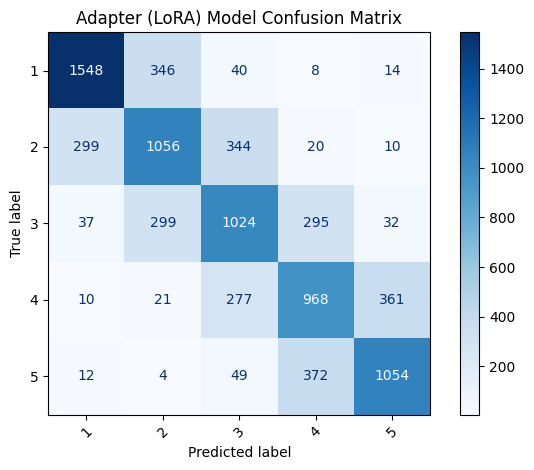

In [19]:
preds = trainer_adapter.predict(test_dataset)
y_true, y_pred = preds.label_ids, preds.predictions.argmax(-1)
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.classes_
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("Adapter (LoRA) Model Confusion Matrix")
plt.tight_layout()
plt.show()

#### Step 11.3: Training Progress Visualization & Loss Analysis

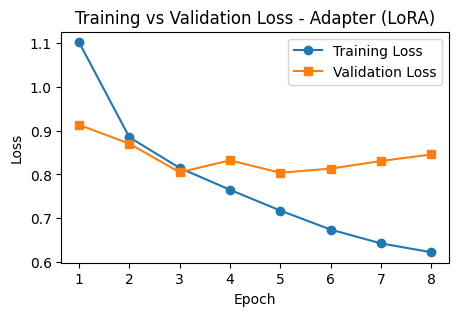

In [20]:
 logs_adapter = trainer_adapter.state.log_history

train_loss_adapter = {}
eval_loss_adapter = {}

for log in logs_adapter:
    if "loss" in log and "epoch" in log:
        train_loss_adapter[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_adapter[float(log["epoch"])] = log["eval_loss"]

epochs_adapter = sorted(set(train_loss_adapter.keys()) | set(eval_loss_adapter.keys()))
train_vals_adapter = [train_loss_adapter.get(e, None) for e in epochs_adapter]
eval_vals_adapter = [eval_loss_adapter.get(e, None) for e in epochs_adapter]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_adapter, train_vals_adapter, label="Training Loss", marker="o")
plt.plot(epochs_adapter, eval_vals_adapter, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Adapter (LoRA)")
plt.legend()
plt.grid(False)
plt.show()


### Step 12: Comprehensive Model Comparison & Performance Visualization

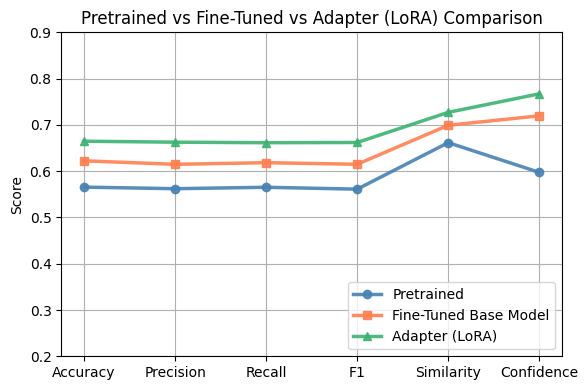

In [26]:
metrics = ["accuracy", "precision", "recall", "f1", "similarity_score", "confidence_score"]

pretrained_vals = np.array([baseline_metrics[f"eval_{m}"] for m in metrics]) / 100
base_vals = np.array([finetuned_metrics[f"eval_{m}"] for m in metrics]) / 100
adapter_vals = np.array([adapter_metrics[f"eval_{m}"] for m in metrics]) / 100

x = np.arange(len(metrics))

plt.figure(figsize=(6, 4))

plt.plot(x, pretrained_vals, marker='o', linestyle='-', linewidth=2.5, alpha=0.9, label="Pretrained", color='steelblue')
plt.plot(x, base_vals, marker='s', linestyle='-', linewidth=2.5, alpha=0.9, label="Fine-Tuned Base Model", color='coral')
plt.plot(x, adapter_vals, marker='^', linestyle='-', linewidth=2.5, alpha=0.9, label="Adapter (LoRA)", color='mediumseagreen')

plt.xticks(x, ["Accuracy", "Precision", "Recall", "F1", "Similarity", "Confidence"], fontsize=10)
plt.ylabel("Score")
plt.ylim(0.20, 0.90)
plt.title("Pretrained vs Fine-Tuned vs Adapter (LoRA) Comparison")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()